# Top Hit Song Prediction
This notebook outlines the process of developing an AI model trained to predict potential top hit songs. New artists can use this tool as a guide to improve their music and increase their chances of reaching the top charts. However, the AI serves as a recommendation tool rather than a guaranteed formula for success.

Additionally, it provides visualizations to help new artists understand which audio features to focus on when creating a popular song and to gain insight into the features that contribute most to a song’s success.

## Dependencies
Here are the dependencies I'm currently using to build the visualization and develop the Top Hit Song model.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import joblib

## Cleaning Data for Visualization
Before using the collected data for visualization, it must firstly be cleaned. This involves removing columns that are not useful for visualization, as well as eliminating any null values and duplicate entries.

I have two datasets to clean: one for high song popularity and one for low song popularity. I chose these datasets because they contain the most recent data from 2024, which is necessary for training the model. The model needs up-to-date data to accurately predict whether a song would be a hit today. After cleaning the data, it will be combined to be used for visualization

### Cleaning High Popularity Song Data

In [ ]:
# Add csv data to songs
high_song_popularity = pd.read_csv("high_popularity_spotify_data.csv")

# Drop useless column
high_song_popularity.drop(columns=['track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url',
                                    'track_id', 'track_album_id', 'type', 'playlist_id'], inplace=True)

# Show the total number of null in each column.
print(high_song_popularity.isnull().sum())

# Test
print(high_song_popularity.head())

energy                      0
tempo                       0
danceability                0
playlist_genre              0
loudness                    0
liveness                    0
valence                     0
track_artist                0
time_signature              0
speechiness                 0
track_popularity            0
track_name                  0
track_album_release_date    0
instrumentalness            0
mode                        0
key                         0
duration_ms                 0
acousticness                0
id                          0
playlist_subgenre           0
dtype: int64
   energy    tempo  danceability playlist_genre  loudness  liveness  valence  \
0   0.592  157.969         0.521            pop    -7.777     0.122    0.535   
1   0.507  104.978         0.747            pop   -10.171     0.117    0.438   
2   0.808  108.548         0.554            pop    -4.169     0.159    0.372   
3   0.910  112.966         0.670            pop    -4.070     0.304

### Cleaning Low Popularity Song Data

In [3]:
# Add csv data to songs
low_song_popularity = pd.read_csv("low_popularity_spotify_data.csv")

# Drop useless column
low_song_popularity.drop(columns=['track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url',
                                    'track_id', 'track_album_id', 'type', 'playlist_id'], inplace=True)

# Drop row containing null for time_signature
low_song_popularity = low_song_popularity.dropna(subset='time_signature')

# Show the total number of null in each column.
print(low_song_popularity.isnull().sum())

time_signature              0
track_popularity            0
speechiness                 0
danceability                0
track_artist                0
duration_ms                 0
energy                      0
playlist_genre              0
playlist_subgenre           0
track_name                  0
mode                        0
track_album_release_date    0
id                          0
instrumentalness            0
valence                     0
key                         0
tempo                       0
loudness                    0
acousticness                0
liveness                    0
dtype: int64


## Audio Features
Here is the description of each audio features in the dataset.

-Energy         =   A measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. The higher it is the engergetic it is.

-Tempo           =   The speed of a track, measured in beats per minute (BPM).

-Danceability    =   A score describing how suitable a track is for dancing based on tempo, rhythm stability, beat strength and overall regularity.

-Loudness        =   The overall loudness of a track in decibels (dB). Higher values indicate louder tracks overall.

-Liveness        =   The likelihood of a track being performed live. Higher values suggest more audience presence.

-Valence         =   The overall musical positiveness(emotion) of a track. High valence sounds happy; low valence sounds sad or angry.

-Speechiness     =   Measures the presence of spoken words.

-Instrumentalness =   The likelihood a track contains no vocals. Values closer to 1.0 suggest solely instrumental tracks.

-Acousticness    =   A confidence measure of whether a track is acoustic(1) or not(0).

-Mode            =   Indicates the modality of the track.

-Key             =   The musical key, represented as an integer from 0 to 11, mapping to standard Pitch class notation.

-Duration_ms     =   The length of the track in milliseconds.

## Visualization and analyze trends


### Compare The Average Popular and Non-popular Audio Features by Song Genres
This bar chart compares the average values of audio features between popular and non-popular songs across different genres. It helps artists gain insights and identify patterns in how features like energy, danceability, and tempo behave in popular versus non-popular songs within each genre.

By analyzing these differences, artists can better understand what characteristics are commonly found in successful songs in their chosen genre. This can guide them in targeting ideal feature values when producing new song.

All audio feature values in the chart are normalized to a scale between 0 and 1. This is important because features like tempo and loudness normally exist on different scales, and normalization ensures a fair visual comparison across all features.

In [ ]:
# Features to include
features = ['energy', 'danceability', 'valence', 'acousticness', 'instrumentalness', 'tempo', 'loudness']

# Combine the 2 data to be use
combined_df = pd.concat([high_song_popularity, low_song_popularity])

feature_min = combined_df[features].min()
feature_max = combined_df[features].max()

# Normalize and retain original values for tooltip
high_norm = high_song_popularity.copy()
low_norm = low_song_popularity.copy()

for feature in features:
    high_norm[feature + '_orig'] = high_song_popularity[feature]
    low_norm[feature + '_orig'] = low_song_popularity[feature]
    high_norm[feature] = (high_song_popularity[feature] - feature_min[feature]) / (feature_max[feature] - feature_min[feature])
    low_norm[feature] = (low_song_popularity[feature] - feature_min[feature]) / (feature_max[feature] - feature_min[feature])

# Unique genres with valid data
genres = sorted(set(high_norm['playlist_genre'].unique().tolist() + low_norm['playlist_genre'].unique().tolist()))
data_by_genre = {}

for genre in genres:
    pop_filtered = high_norm[high_norm["playlist_genre"] == genre]
    non_pop_filtered = low_norm[low_norm["playlist_genre"] == genre]
    if pop_filtered.empty or non_pop_filtered.empty:
        continue

    pop_avg = pop_filtered[features].mean()
    non_pop_avg = non_pop_filtered[features].mean()
    pop_raw = pop_filtered[[f + "_orig" for f in features]].mean()
    non_pop_raw = non_pop_filtered[[f + "_orig" for f in features]].mean()

    data_by_genre[genre] = {
        "pop_norm": pop_avg,
        "non_pop_norm": non_pop_avg,
        "pop_raw": pop_raw,
        "non_pop_raw": non_pop_raw
    }

# Keep only genres with data
genres = list(data_by_genre.keys())
initial_genre = genres[0]

# Create figure with initial genre
fig = go.Figure()

# Add normalized bars with raw values in customdata
fig.add_trace(go.Bar(
    name='Popular songs',
    x=features,
    y=data_by_genre[initial_genre]['pop_norm'],
    marker_color='green',
    customdata=data_by_genre[initial_genre]['pop_raw'].values.reshape(-1, 1),
    hovertemplate='%{x}<br>Normalized: %{y:.2f}<br>Raw: %{customdata[0]:.2f}<extra></extra>'
))

fig.add_trace(go.Bar(
    name='Non-popular songs',
    x=features,
    y=data_by_genre[initial_genre]['non_pop_norm'],
    marker_color='blue',
    customdata=data_by_genre[initial_genre]['non_pop_raw'].values.reshape(-1, 1),
    hovertemplate='%{x}<br>Normalized: %{y:.2f}<br>Raw: %{customdata[0]:.2f}<extra></extra>'
))

# Dropdown buttons
dropdown_buttons = []
for genre in genres:
    dropdown_buttons.append({
        'label': genre.title(),
        'method': 'update',
        'args': [
            {
                'y': [
                    data_by_genre[genre]['pop_norm'],
                    data_by_genre[genre]['non_pop_norm']
                ],
                'customdata': [
                    data_by_genre[genre]['pop_raw'].values.reshape(-1, 1),
                    data_by_genre[genre]['non_pop_raw'].values.reshape(-1, 1)
                ]
            },
            {
                'title': f'Feature Comparison (Normalized with Raw Tooltips): Popular vs. Non-Popular {genre.title()} Songs'
            }
        ]
    })

# Layout
fig.update_layout(
    updatemenus=[
        {
            'buttons': dropdown_buttons,
            'direction': 'down',
            'showactive': True,
            'x': 1.0,
            'y': 1.2,
            'xanchor': 'left',
            'yanchor': 'top'
        }
    ],
    title=f'Feature Comparison (Normalized with Raw Tooltips): Popular vs. Non-Popular {initial_genre.title()} Songs',
    xaxis_title='Features',
    yaxis_title='Normalized Value (0 - 1)',
    barmode='group',
    template='plotly_dark',
    height=500
)

fig.show()

# Test
print(high_song_popularity.head())

   energy    tempo  danceability playlist_genre  loudness  liveness  valence  \
0   0.592  157.969         0.521            pop    -7.777     0.122    0.535   
1   0.507  104.978         0.747            pop   -10.171     0.117    0.438   
2   0.808  108.548         0.554            pop    -4.169     0.159    0.372   
3   0.910  112.966         0.670            pop    -4.070     0.304    0.786   
4   0.783  149.027         0.777            pop    -4.477     0.355    0.939   

            track_artist  time_signature  speechiness  track_popularity  \
0  Lady Gaga, Bruno Mars               3       0.0304               100   
1          Billie Eilish               4       0.0358                97   
2          Gracie Abrams               4       0.0368                93   
3      Sabrina Carpenter               4       0.0634                81   
4       ROSÉ, Bruno Mars               4       0.2600                98   

           track_name track_album_release_date  instrumentalness  mo

#### Result
 From the chart, we can see that some genres differ significantly in their audio features. For example, classical music genres has much lower energy compared to hip hop. In fact, the energy difference for popular songs between these two genres is 0.515. Classical music genres also shows higher instrumentalness than hip hop.

On the other hand, some genres, such as pop and Latin, have very similar average audio feature values. This makes it difficult to distinguish them based solely on these features.

Therefore, depending on the genre an artist chooses, they can analyze and align their song’s audio features with those that are commonly found in popular songs within that genre.

### Heatmap Correlation for Popular Songs Between Audio Features
This heatmap helps artists understand the relationships between different audio features. A strong positive correlation (closer to +1) means two features increase together, for example, higher energy often means higher loudness. A strong negative correlation (closer to –1) means as one feature increases, the other decreases, such as more acoustic songs often being less energetic. A correlation close to 0 means there's no meaningful relationship between the two features.

Note, this heatmap is not about predicting popularity directly. Instead, it shows how features relate to one another across popular songs. Artists can use it to see which features influence each other, for example, if you want to raise your song’s danceability, the heatmap can show which other traits like energy or valence might help.

In [6]:
# Define features
features = ['energy', 'danceability', 'valence', 'acousticness', 'instrumentalness', 'tempo', 'loudness']

# Normalize 'tempo' and 'loudness' for both datasets
scaler = MinMaxScaler()
high_song_popularity[['tempo', 'loudness']] = scaler.fit_transform(high_song_popularity[['tempo', 'loudness']])

# Correlation matrices
corr_popular = high_song_popularity[features].corr()

# Popular songs heatmap
fig_popular = px.imshow(
    corr_popular,
    text_auto='.2f',
    color_continuous_scale='Viridis',
    labels=dict(x="Audio Feature", y="Audio Feature", color="Correlation")
)

fig_popular.update_layout(
    title="Correlation Between Audio Features (Popular Songs)",
    width=700,
    height=700,
    template="plotly_dark"
)

# Show both
fig_popular.show()

# Test
print(high_song_popularity.head())

   energy     tempo  danceability playlist_genre  loudness  liveness  valence  \
0   0.592  0.677528         0.521            pop  0.798122     0.122    0.535   
1   0.507  0.347125         0.747            pop  0.744848     0.117    0.438   
2   0.808  0.369385         0.554            pop  0.878410     0.159    0.372   
3   0.910  0.396931         0.670            pop  0.880613     0.304    0.786   
4   0.783  0.621774         0.777            pop  0.871556     0.355    0.939   

            track_artist  time_signature  speechiness  track_popularity  \
0  Lady Gaga, Bruno Mars               3       0.0304               100   
1          Billie Eilish               4       0.0358                97   
2          Gracie Abrams               4       0.0368                93   
3      Sabrina Carpenter               4       0.0634                81   
4       ROSÉ, Bruno Mars               4       0.2600                98   

           track_name track_album_release_date  instrumentalne

#### Result
From the visualization, we can observe strong, weak, and negligible correlations between audio features in popular songs:

Strong positive correlations:
    
    -Energy and loudness: 0.69, indicating that high-energy songs tend to be louder.
    -Danceability and valence: 0.35
    -Energy and valence: 0.33, suggesting that more energetic songs also tend to feel more positive.

Strong negative correlations:

    -Acousticness and energy: –0.61, meaning more acoustic songs are typically lower in energy and have a more relaxed or chill feel.
    -Acousticness and loudness: –0.48
    -Instrumentalness and loudness: –0.36

No meaningful correlation:
    
    -Most feature pairs that fall between –0.1 and 0.1, indicating a weak or non-existent relationship.

These correlations give artists a better understanding of how adjusting one feature might impact others when crafting songs that resemble current popular songs.

### Heatmap Correlation for Popular Audio Features Between Genres
This visualization gives artists an overview of how audio features correlate with one another across different genres. It provides insight into how, depending on the genre, certain audio features may show strong positive correlations, while others may have negative or no correlation at all.

The goal is to help artists prioritize which audio features are most strongly associated with a specific genre.

In [ ]:
# Define features
features = ['energy', 'danceability', 'valence', 'acousticness', 'instrumentalness', 'tempo', 'loudness']

# Normalize 'tempo' and 'loudness' for fair comparison
scaler = MinMaxScaler()
high_song_popularity[['tempo', 'loudness']] = scaler.fit_transform(high_song_popularity[['tempo', 'loudness']])

# Get all genres
genres = sorted(high_song_popularity['playlist_genre'].unique())

# Define the heatmap function
def plot_heatmap(genre):
    subset = high_song_popularity[high_song_popularity['playlist_genre'] == genre][features]
    corr = subset.corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='viridis', vmin=-1, vmax=1, square=True)
    plt.title(f'Audio Feature Correlation Heatmap - {genre.capitalize()} (Popular Songs)', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Create dropdown widget
genre_selector = widgets.Dropdown(
    options=genres,
    description='Genre:',
    value=genres[0],
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Bind dropdown to function
interaction = widgets.interact(plot_heatmap, genre=genre_selector)

# Test
print(high_song_popularity.head())

interactive(children=(Dropdown(description='Genre:', layout=Layout(width='300px'), options=('afrobeats', 'ambi…

   energy     tempo  danceability playlist_genre  loudness  liveness  valence  \
0   0.592  0.677528         0.521            pop  0.798122     0.122    0.535   
1   0.507  0.347125         0.747            pop  0.744848     0.117    0.438   
2   0.808  0.369385         0.554            pop  0.878410     0.159    0.372   
3   0.910  0.396931         0.670            pop  0.880613     0.304    0.786   
4   0.783  0.621774         0.777            pop  0.871556     0.355    0.939   

            track_artist  time_signature  speechiness  track_popularity  \
0  Lady Gaga, Bruno Mars               3       0.0304               100   
1          Billie Eilish               4       0.0358                97   
2          Gracie Abrams               4       0.0368                93   
3      Sabrina Carpenter               4       0.0634                81   
4       ROSÉ, Bruno Mars               4       0.2600                98   

           track_name track_album_release_date  instrumentalne

#### Result
From the results, you can observe that some genres share similar audio feature correlations. For example, Pop and Latin exhibit similar patterns. However, many other genres differ significantly for instance, Country and Lofi.

Keep in mind that this analysis is based on the available dataset, which consists of 1,686 popular songs.

## Model
This section explains the process of developing the model to predict top hit songs. The steps include cleaning the data, training the model, and then saving it for use in the application

### Cleaning Data for The Model
This is the same process as the visualization.

In [ ]:
# Add csv data to songs
high_popularity = pd.read_csv("high_popularity_spotify_data.csv")
low_popularity = pd.read_csv("low_popularity_spotify_data.csv")

# Combined the 2 data
combined_popularity_df = pd.concat([high_popularity, low_popularity], ignore_index=True)

# Create "hit" column from "track_popularity" for 1 and 0 input. If populartiy is lower than 70 it's 0 and higher it's 1
combined_popularity_df['hit'] = combined_popularity_df['track_popularity'].apply(lambda x: 1 if x >= 70 else 0)

# Drop non-numeric or irrelevant columns
columns_to_drop = ['track_name', 'track_artist', 'id', 'track_popularity', 'track_album_release_date',
                    'playlist_genre', 'playlist_subgenre', 'track_href', 'uri', 'track_id', 'track_album_id', 'type', 'playlist_id',
                    'track_album_name', 'playlist_name', 'analysis_url']


# Drop useless columns for the model
combined_popularity_df = combined_popularity_df.drop(columns=columns_to_drop)

# Test
#print(combined_popularity_df.columns)
#print(combined_popularity_df.head())
#print(high_song_popularity.head())
#print(combined_popularity_df.isnull().sum())


### Train Model
This section is to train the model with the clean data. The model that is being used is called XGBoost. XGBoost is being used because it's a high gradient boost, which is a machine learning technique 

In [9]:
# Split feature and target
X = combined_popularity_df.drop('hit', axis=1) # Audio features only
y = combined_popularity_df['hit'] # This is the target which conatains the answer sheet with hit 0 means no hit and 1 means hit

# Step 2: Scale numeric features
scaler = MinMaxScaler()
X_scaled = X.copy()
X_scaled[['tempo', 'loudness']] = scaler.fit_transform(X_scaled[['tempo', 'loudness']])

# Step 3: Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Handle missing values in training data
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Step 5: Apply SMOTE to balanced training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)

# Step 6: Train model
model = XGBClassifier(eval_metric="logloss")
model.fit(X_train_smote, y_train_smote)

# Step 7: Predict and evaluate
y_pred = model.predict(X_test_imputed)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Hit", "Hit"]))

#xgb.plot_importance(model)
#plt.title("Feature Importance")
#plt.show()

Confusion Matrix:
[[557 118]
 [126 166]]

Classification Report:
              precision    recall  f1-score   support

     Not Hit       0.82      0.83      0.82       675
         Hit       0.58      0.57      0.58       292

    accuracy                           0.75       967
   macro avg       0.70      0.70      0.70       967
weighted avg       0.75      0.75      0.75       967



Confusion Matrix:
[[598  77]
 [144 148]]

Classification Report:
              precision    recall  f1-score   support

     Not Hit       0.81      0.89      0.84       675
         Hit       0.66      0.51      0.57       292

    accuracy                           0.77       967
   macro avg       0.73      0.70      0.71       967
weighted avg       0.76      0.77      0.76       967



<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

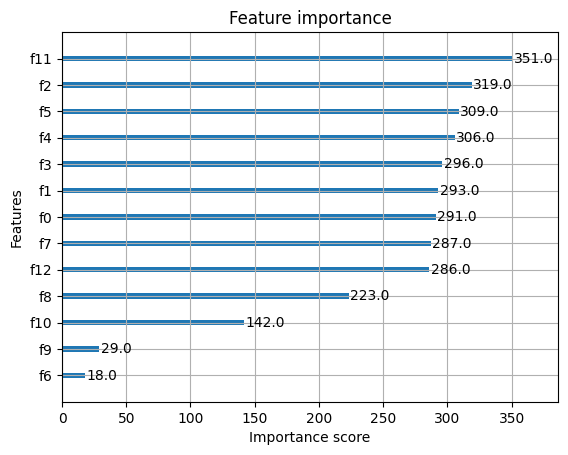

In [10]:
# Split feature and target
X = combined_popularity_df.drop('hit', axis=1) # Audio features only
y = combined_popularity_df['hit'] # This is the target which conatains the answer sheet with hit 0 means no hit and 1 means hit

# Show the columns of X
#print(X.dtypes)

# Normalize the feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train model
model = XGBClassifier(eval_metric="logloss")
model.fit(X_train, y_train)

# Predict and evalute
y_pred = model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Hit", "Hit"]))

xgb.plot_importance(model)
#plt.title("Feature Importance")
#plt.show()

### Save The Model and Scaler
This section is to save the model and the scaler to be used for the application.

In [11]:
# Save the trained model to a file
joblib.dump(model, "hit_predictor_model.pkl")

['hit_predictor_model.pkl']

In [12]:
# Save the scaler used for feature normalization
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [13]:
# Add csv data to songs
hs_popularity = pd.read_csv("high_popularity_spotify_data.csv")

# Drop useless column
hs_popularity.drop(columns=['track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url',
                                    'track_id', 'track_album_id', 'type', 'playlist_id'], inplace=True)

# Show the total number of null in each column.
#print(hs_popularity.isnull().sum())

#--------------------------------------------------------------------------------------------------------

# Add csv data to songs
lw_popularity = pd.read_csv("low_popularity_spotify_data.csv")

# Drop useless column
lw_popularity.drop(columns=['track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url',
                                    'track_id', 'track_album_id', 'type', 'playlist_id'], inplace=True)

# Drop row containing null for time_signature
lw_popularity = lw_popularity.dropna(subset='time_signature')

# Show the total number of null in each column.
#print(lw_popularity.isnull().sum())

#------------------------------------------------------------------------------------

testc_pop = pd.concat([hs_popularity, lw_popularity], ignore_index=True)

# Define features
features = ['energy', 'danceability', 'valence', 'acousticness', 'instrumentalness', 'tempo', 'loudness']

# Normalize 'tempo' and 'loudness' for both datasets
scaler = MinMaxScaler()
testc_pop[['tempo', 'loudness']] = scaler.fit_transform(testc_pop[['tempo', 'loudness']])

#testc_pop =testc_pop.dropna()
#print(testc_pop.isnull().sum())
#print(testc_pop.head())
#print(len(testc_pop))

#---------------------------------------------------------------------------------

# Add csv data to songs
h_popularity = pd.read_csv("high_popularity_spotify_data.csv")
l_popularity = pd.read_csv("low_popularity_spotify_data.csv")

# Combined popularity
c_popularity_df = pd.concat([h_popularity, l_popularity], ignore_index=True)

# Create "hit" column from "track_popularity" for 1 and 0 input. If populartiy is lower than 70 it's 0 and higher it's 1
c_popularity_df['hit'] = c_popularity_df['track_popularity'].apply(lambda x: 1 if x >= 70 else 0)

# Drop non-numeric or irrelevant columns
columns_to_drop = ['track_name', 'track_artist', 'id', 'track_popularity', 'track_album_release_date',
                    'playlist_genre', 'playlist_subgenre', 'track_href', 'uri', 'track_id', 'track_album_id', 'type', 'playlist_id',
                    'track_album_name', 'playlist_name', 'analysis_url']

# Drop useless columns for the model
c_popularity_df = c_popularity_df.drop(columns=columns_to_drop)

c_popularity_df =c_popularity_df.dropna()

# Show the total number of null in each column.
#print(c_popularity_df.isnull().sum())

# Normalize 'tempo' and 'loudness' for both datasets
scaler_test = MinMaxScaler()
c_popularity_df[['tempo', 'loudness']] = scaler_test.fit_transform(c_popularity_df[['tempo', 'loudness']])

# Split feature and target
X = c_popularity_df.drop('hit', axis=1) # Audio features only
y = c_popularity_df['hit'] # This is the target which conatains the answer sheet with hit 0 means no hit and 1 means hit


# Normalize the feature
#scaler_test = StandardScaler()
#X_scaled_test = scaler_test.fit_transform(X)
#X[['tempo', 'loudness']] = scaler_test.fit_transform(X[['tempo', 'loudness']])

# Convert X_scaled back to data and print top 5 to see
X_scaled_df_test = pd.DataFrame(X, columns=X.columns)
#print(X_scaled_df_test.head())
#print(len(X))

# Split data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train model
#model = XGBClassifier(eval_metric="logloss")
#model.fit(X_train, y_train)

# Predict and evalute
#y_pred = model.predict(X_test)
#print("Confusion Matrix:")
#print(confusion_matrix(y_test, y_pred))

#print("\nClassification Report:")
#print(classification_report(y_test, y_pred, target_names=["Not Hit", "Hit"]))

#xgb.plot_importance(model)
#plt.title("Feature Importance")
#plt.show()

In [14]:
# Add csv data to songs
high_p = pd.read_csv("high_popularity_spotify_data.csv")

# Drop useless column
high_p.drop(columns=['track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url',
                                    'track_id', 'track_album_id', 'type', 'playlist_id'], inplace=True)

# Show the total number of null in each column.
#print(hs_popularity.isnull().sum())

#--------------------------------------------------------------------------------------------------------

# Add csv data to songs
low_p = pd.read_csv("low_popularity_spotify_data.csv")

# Drop useless column
low_p.drop(columns=['track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url',
                                    'track_id', 'track_album_id', 'type', 'playlist_id'], inplace=True)

# Drop row containing null for time_signature
low_p = low_p.dropna(subset='time_signature')

# Show the total number of null in each column.
#print(lw_popularity.isnull().sum())

#------------------------------------------------------------------------------------

# Define features
#features = ['energy', 'danceability', 'valence', 'acousticness', 'instrumentalness', 'tempo', 'loudness']

# Normalize 'tempo' and 'loudness' for both datasets
scaler = MinMaxScaler()
high_p[['tempo', 'loudness']] = scaler.fit_transform(high_p[['tempo', 'loudness']])

print(high_p.head())
#print(len(hs_popularity)

   energy     tempo  danceability playlist_genre  loudness  liveness  valence  \
0   0.592  0.677528         0.521            pop  0.798122     0.122    0.535   
1   0.507  0.347125         0.747            pop  0.744848     0.117    0.438   
2   0.808  0.369385         0.554            pop  0.878410     0.159    0.372   
3   0.910  0.396931         0.670            pop  0.880613     0.304    0.786   
4   0.783  0.621774         0.777            pop  0.871556     0.355    0.939   

            track_artist  time_signature  speechiness  track_popularity  \
0  Lady Gaga, Bruno Mars               3       0.0304               100   
1          Billie Eilish               4       0.0358                97   
2          Gracie Abrams               4       0.0368                93   
3      Sabrina Carpenter               4       0.0634                81   
4       ROSÉ, Bruno Mars               4       0.2600                98   

           track_name track_album_release_date  instrumentalne